In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os


In [2]:
DATA_DIR = "/Users/timberzhang/Documents/Documents/2024-JustWatch/Data"
FILL_NAN = np.nan
CLUSTER_MIN_EPS = 25
CLUSTER_MIN_SAMPLE = 5
MIN_DTW_WINDOW = 5

VR_SCALE = 0.001207812
VR_ZDIST = 1
EYE_SAMPLE_RATE = 50
EYE_SAMPLE_TIME = (1 / EYE_SAMPLE_RATE) * 1000
SCREEN_SIZE = [1280, 720]

VIDEO_SIZE = [1920, 1080]
VIDEO_FPS = 30
BALL_TRAJ = None

In [3]:

def fetch_eye_data(_raw_eye_data:str):
    _eye_data_rows = _raw_eye_data.split(";")
    eye_data = {}   
    names = _eye_data_rows[0].split(" ")
    for idx, row in enumerate(_eye_data_rows):
        if idx == 0 : continue

        cur_data = row.split(" ")
        try:
            eye_data[idx] = {
                names[0] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[0]),
                names[1] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[1]),
                names[2] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[2]),
                names[3] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[3]),
            }
        except:
            eye_data[idx] = {
                names[0] : FILL_NAN,
                names[1] : FILL_NAN,
                names[2] : FILL_NAN,
                names[3] : FILL_NAN,
            }

    return eye_data


In [4]:

def fetch_trajectory(dir_path:str):
    res = {}

    p_traj = pd.read_csv(os.path.join(dir_path, "pingpang.csv"))
    w_traj = pd.read_csv(os.path.join(dir_path, "tennis.csv"))
    _temp_all = pd.concat([p_traj, w_traj], axis=0)
    _temp_all["position"] = _temp_all["position"].apply(lambda x : x.replace(" ", ""))

    for v_id, v_df in _temp_all.groupby(by="video_name"):

        _x = v_df["position"].apply(lambda x : x.split(",")[0][1:]).to_numpy(dtype=np.int16)
        _y = v_df["position"].apply(lambda x : x.split(",")[1][:-1]).to_numpy(dtype=np.int16)

        # reverse the y-axis
        _y = (_y - VIDEO_SIZE[1]) * -1

        # scale and shift
        _x = (_x / VIDEO_SIZE[0]) * SCREEN_SIZE[0] - (SCREEN_SIZE[0] // 2)
        _y = (_y / VIDEO_SIZE[1]) * SCREEN_SIZE[1] - (SCREEN_SIZE[1] // 2)

        _f = v_df["frame_number"].to_numpy(dtype=np.int16)
        _r = v_df["round"].to_numpy(dtype=np.int16)
        _temp_df = pd.DataFrame(
            np.array([_f, _x, _y, _r]),
        ).T
        _temp_df.index = range(1, _f.size+1)
        _temp_df.columns = ["frame", "Ball.x", "Ball.y", "round"]

        res[v_id] = _temp_df.to_dict()

    return res

In [28]:
from scipy.spatial import KDTree

def interplate_and_align(base_df:pd.DataFrame, align_df:pd.DataFrame, base_rate:int, align_rate:int, convert_dist=False):
    share_rate = abs(base_rate * align_rate) // np.gcd(base_rate, align_rate)
    
    align_df["frame"] = align_df["frame"] * (share_rate // align_rate)
    temp_index= np.array(range(1, int(base_df["frame"].max()+1) * (share_rate // base_rate)))

    temp_time_df = pd.DataFrame(temp_index, index=temp_index, columns=["frame"])
    _index = temp_time_df.index
    temp_time_df = temp_time_df.merge(align_df, how="left", on="frame")
    temp_time_df.index = _index
    ## interplate
    for col in temp_time_df.columns:
        if col=="round": continue
        temp_time_df[col] = temp_time_df[col].interpolate(method='linear')
    ## ensure first row is not empty
    temp_time_df.ffill(inplace=True)
    temp_time_df.bfill(inplace=True)
    
    base_df["frame"] = base_df["frame"] * (share_rate // base_rate)
    _index = base_df.index
    alined_df = base_df.merge(temp_time_df, how="left", on="frame", )
    alined_df.index = _index
    alined_df["frame"] = alined_df["frame"] // (share_rate // base_rate)

    if convert_dist:
        alined_df = alined_df * VR_SCALE
        alined_df["frame"] = alined_df["frame"] // VR_SCALE

    alined_df.ffill(inplace=True)
    alined_df.bfill(inplace=True)

    return alined_df


def count_points_in_radius(ball_df:pd.DataFrame, eye_df:pd.DataFrame, radius):
    # Build a k-d tree from the points DataFrame
    points_tree = KDTree(eye_df[['Screen.x', 'Screen.y']])
    
    count_list = []
    
    for i, trajectory_point in ball_df.iterrows():
        # Query the k-d tree for points within the radius
        indices = points_tree.query_ball_point([trajectory_point['Ball.x'], trajectory_point['Ball.y']], r=radius)
        count_list += indices
    
    return list(set(count_list))

def find_match_round(eye_data_df:pd.DataFrame, video_id, radius=15, inner_percent=0.9):
    res = []
    if not BALL_TRAJ: 
        return res

    eye_data_df["frame"] = eye_data_df.index
    ball_data_df = pd.DataFrame(BALL_TRAJ[video_id])
    assert "round" in ball_data_df.columns, "Missing 'round' in ball trajectory file"

    aligned_df = interplate_and_align(eye_data_df, ball_data_df, EYE_SAMPLE_RATE, VIDEO_FPS, convert_dist=False)

    for _round in aligned_df["round"].value_counts().index:
        temp = aligned_df[aligned_df["round"]==_round]
        inner_counts = count_points_in_radius(temp.loc[:, ["Ball.x", "Ball.y"]], temp.loc[:, ["Screen.x", "Screen.y"]], radius=radius)

        # check_df = temp.iloc[inner_counts, :]
        # max_x, min_x = check_df["Screen.x"].max(), check_df["Screen.x"].min()
        # max_y, min_y = check_df["Screen.y"].max(), check_df["Screen.y"].min()
        # dis = np.sqrt((max_x - min_x)**2 + (max_y - min_y)**2)
        dis = radius

        if (len(inner_counts) / temp.shape[0]) > inner_percent and dis >= radius:
            res.append(_round)


    return res

In [29]:
from tslearn.metrics import dtw as ts_dtw
from scipy.spatial.distance import cdist
from scipy.spatial.distance import directed_hausdorff

def shape_based_distance(series1, series2):
    return max(directed_hausdorff(series1, series2)[0], directed_hausdorff(series2, series1)[0])


def compute_dtw(line_1:pd.DataFrame, line_2:pd.DataFrame, scale_to_percentage=False, scale_metrics="mean"):
    assert line_1.shape[-1] == line_2.shape[-1]

    res = ts_dtw(line_1, line_2)

    if scale_to_percentage:
        mat = shape_based_distance(line_1, line_2)
        if scale_metrics=="max":
            res = (res / mat.max()) *100
        elif scale_metrics=="start":
            scale = np.sqrt((line_1.iloc[0, :]["Screen.x"] - line_2.iloc[0, :]["Ball.x"])**2 + (line_1.iloc[0, :]["Screen.y"] - line_2.iloc[0, :]["Ball.y"])**2)
            res = (res / scale) * 100
        elif scale_metrics=="end":
            scale = np.sqrt((line_1.iloc[-1, :]["Screen.x"] - line_2.iloc[-1, :]["Ball.x"])**2 + (line_1.iloc[-1, :]["Screen.y"] - line_2.iloc[-1, :]["Ball.y"])**2)
            res = (res / scale) * 100
        else:
            res = (res / mat.mean()) *100 

    return res


def compute_gradient_dtw(line_1:pd.DataFrame, line_2:pd.DataFrame, order:int=1, time_scale=1, scale_to_percentage=False):
    assert line_1.shape[-1] == line_2.shape[-1]
    assert "time" in line_1.columns or "frame" in line_1.columns, "Please include index, time, or frame (named 'time') in the line_1 DataFrame"
    assert "time" in line_2.columns or "frame" in line_2.columns, "Please include index, time, or frame (named 'time') in the line_2 DataFrame"
    assert order>=1, "Gradient order must larger or equal to 1"
    
    ## convert frame to time
    if "frame" in line_1.columns:
        line_1["time"] = line_1["frame"] * EYE_SAMPLE_TIME * time_scale
    if "frame" in line_2.columns:
        line_2["time"] = line_2["frame"] * EYE_SAMPLE_TIME * time_scale

    ## create gradient column
    line_1_grad_col, line_2_grad_col = [], []
    for col in line_1.columns:
        if col == "time" or col == "frame": continue
        line_1[f"{col}.grad"] = line_1[col]
        line_1_grad_col.append(f"{col}.grad")
    for col in line_2.columns:
        if col == "time" or col == "frame": continue
        line_2[f"{col}.grad"] = line_2[col]
        line_2_grad_col.append(f"{col}.grad")
    
    ## compute the gradient
    for _ in range(0, order):
        for col in line_1_grad_col:
            line_1[col] = np.gradient(line_1[col], line_1["time"])
        for col in line_2_grad_col:
            line_2[col] = np.gradient(line_2[col], line_2["time"])

    return compute_dtw(line_1[line_1_grad_col], line_2[line_2_grad_col], scale_to_percentage=scale_to_percentage)

In [30]:
def given_minmax_scale(data:pd.DataFrame, minmax, feature_range=[0,1], axis=0):
    res = []
    for _i in data.index if axis==1 else data.columns:
        scale = (feature_range[1] - feature_range[0]) / (minmax[1] - minmax[0])
        X_scaled = scale * (data[_i] - minmax[0])
        res.append(X_scaled)

    return pd.DataFrame(res) if axis==1 else pd.DataFrame(res).T

In [31]:
from sklearn.preprocessing import minmax_scale


def interplate_enlarge(ori_df:pd.DataFrame, size:int):
    ori_df = ori_df.reset_index(drop=True)
    ori_df.index = [int(np.round(i * (size / ori_df.shape[0]))) for i in ori_df.index ]
    new_index = pd.Index(range(0, min(size, ori_df.index[-1]+1)))
    # print(new_index)
    # print(size / ori_df.shape[0])
    ori_df = ori_df.reindex(new_index).interpolate()
    return ori_df


def find_match_round_dtw(eye_data_df:pd.DataFrame, video_id, order=0, scale_raw_data=False, dtw_th=1.0):
    res = {}
    dtw_res = {}
    if not BALL_TRAJ: 
        return res

    eye_data_df["frame"] = eye_data_df.index
    ball_data_df = pd.DataFrame(BALL_TRAJ[video_id])
    assert "round" in ball_data_df.columns, "Missing 'round' in ball trajectory file"

    aligned_df = interplate_and_align(eye_data_df, ball_data_df, EYE_SAMPLE_RATE, VIDEO_FPS, convert_dist=False)
    if scale_raw_data:
        aligned_df.loc[:, ["Screen.x", "Ball.x", "Screen.y", "Ball.y"]] = minmax_scale(aligned_df.loc[:, ["Screen.x", "Ball.x", "Screen.y", "Ball.y"]], axis=0)

    for _round in aligned_df["round"].value_counts(sort=False).index:
        temp = aligned_df[aligned_df["round"]==_round]

        match_indice = None
        min_dtw = np.inf
        for idx in temp.index:
            for window_size in range(MIN_DTW_WINDOW, temp.shape[0]):
                # temp_window = aligned_df.loc[_shift_idx:_shift_idx+window_size, :]
                temp_window = aligned_df.loc[ idx : idx + window_size, :]
                if temp_window.shape[0] < MIN_DTW_WINDOW: continue
                _indices = temp_window.index

                if temp_window.shape[0] < temp.shape[0]:
                    temp_window = interplate_enlarge(temp_window, size=temp.shape[0])

                if order==0:
                    _dtw = compute_dtw(
                        line_1 = temp.loc[:, ["Ball.x", "Ball.y"]],
                        line_2 = temp_window.loc[:, ["Screen.x", "Screen.y"]],
                        scale_to_percentage=False
                    )
                elif order>0:
                    _dtw = compute_gradient_dtw(
                            line_1=temp.loc[:, ["frame", "Ball.x", "Ball.y"]],
                            line_2=temp_window.loc[:, ["frame", "Screen.x", "Screen.y"]],
                            order=order,
                            scale_to_percentage=False
                    )
                else:
                    raise Exception("Order of gradient must be positive")
                
                if _dtw < min_dtw:
                    min_dtw = _dtw
                    match_indice = _indices
              
        dtw_res[_round] = min_dtw
        if min_dtw <= dtw_th:
            res[_round] = match_indice

    return res, dtw_res

In [32]:
def find_match_round_dtw_kmp(eye_data_df:pd.DataFrame, video_id, order=0, scale_raw_data=False, dtw_th=1.0):
    res = {}
    dtw_res = {}
    # dtw_value = []
    if not BALL_TRAJ: 
        return res

    eye_data_df["frame"] = eye_data_df.index
    ball_data_df = pd.DataFrame(BALL_TRAJ[video_id])
    assert "round" in ball_data_df.columns, "Missing 'round' in ball trajectory file"

    aligned_df = interplate_and_align(eye_data_df, ball_data_df, EYE_SAMPLE_RATE, VIDEO_FPS, convert_dist=False)
    if scale_raw_data:
        aligned_df.loc[:, ["Screen.x", "Ball.x", "Screen.y", "Ball.y"]] = minmax_scale(aligned_df.loc[:, ["Screen.x", "Ball.x", "Screen.y", "Ball.y"]], axis=0)

    for _round in aligned_df["round"].value_counts(sort=False).index:
        temp = aligned_df[aligned_df["round"]==_round]

        match_indice = None
        min_dtw = np.inf
        _shift_idx = temp.index[0]
        _last_idx = temp.index[0] + MIN_DTW_WINDOW
        # for window_size in range(MIN_DTW_WINDOW, temp.shape[0]):
        max_idx = list(aligned_df[(aligned_df["round"]==_round+1) | (aligned_df["round"]==_round)].index)[-1]

        while _last_idx < max_idx:
            # temp_window = aligned_df.loc[_shift_idx:_shift_idx+window_size, :]
            temp_window = aligned_df.loc[ _shift_idx : _last_idx, :]
            _indices = temp_window.index

            if temp_window.shape[0] < temp.shape[0]:
                temp_window = interplate_enlarge(temp_window, size=temp.shape[0])

            if temp_window.shape[0] < MIN_DTW_WINDOW: continue

            if order==0:
                _dtw = compute_dtw(
                    line_1 = temp.loc[:, ["Ball.x", "Ball.y"]],
                    line_2 = temp_window.loc[:, ["Screen.x", "Screen.y"]],
                    scale_to_percentage=False
                )
            elif order>0:
                _dtw = compute_gradient_dtw(
                        line_1=temp.loc[:, ["frame", "Ball.x", "Ball.y"]],
                        line_2=temp_window.loc[:, ["frame", "Screen.x", "Screen.y"]],
                        order=order,
                        scale_to_percentage=False
                )
            else:
                raise Exception("Order of gradient must be positive")
            
            _last_idx += 1
            if _dtw < min_dtw:
                min_dtw = _dtw
                match_indice = _indices
            else:
                _shift_idx = _last_idx
                _last_idx = _last_idx + MIN_DTW_WINDOW

        dtw_res[_round] = min_dtw
        if min_dtw <= dtw_th:
            res[_round] = match_indice

    return res, dtw_res

In [33]:
def find_match_round_hit(eye_data_df:pd.DataFrame, video_id, time_range=10, dist=250):
    res ={}
    if not BALL_TRAJ: 
        return res

    eye_data_df["frame"] = eye_data_df.index
    ball_data_df = pd.DataFrame(BALL_TRAJ[video_id])
    assert "round" in ball_data_df.columns, "Missing 'round' in ball trajectory file"

    aligned_df = interplate_and_align(eye_data_df, ball_data_df, EYE_SAMPLE_RATE, VIDEO_FPS, convert_dist=False)

    aligned_df["hit"] = aligned_df["round"] - aligned_df["round"].shift(1)
    hits_indices = aligned_df[aligned_df["hit"]==1].index

    for idx, _hit in enumerate(hits_indices):
        index_range = [_hit-time_range, _hit+time_range]
        temp = aligned_df.loc[index_range[0]:index_range[1], :]
        eye_max_dist = np.sqrt((temp["Screen.x"].max() - temp["Screen.x"].min())**2 + (temp["Screen.y"].max() - temp["Screen.y"].min())**2)

        if eye_max_dist >= dist:
            res[aligned_df.loc[_hit, "round"]] = list(temp.index)

    return res

In [34]:
## Timber
# data = pd.read_csv('Study22682754.csv')

## Patient
# data = pd.read_csv('Patients\\Study63104348.csv')

## Control
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24071008_AD.csv")
data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/Test_AD.csv")
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24071512_AD.csv")
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24070904_AD.csv")

In [35]:
_single_person_data_dict = {}
_videos = {}

for _, row in data.iterrows():
    _eye_data = fetch_eye_data(row["EyeData"])
    v_id = row["videoName"]
    if v_id in _single_person_data_dict.keys(): 
        _videos[v_id] += 1
        v_id = v_id + f"_{_videos[v_id]}"
    else:
        _videos[v_id] = 1
    _single_person_data_dict[v_id] = _eye_data

In [36]:
BALL_TRAJ = fetch_trajectory(DATA_DIR)

In [37]:
video_id = "p7"
ball_data = pd.DataFrame(BALL_TRAJ[video_id.split("_")[0]])

In [38]:
eye_data = pd.DataFrame(_single_person_data_dict[video_id]).T
eye_data.ffill(inplace=True)
eye_data.bfill(inplace=True)

eye_data

Screen.x  Screen.y  LeftPupil  RightPupil
1     -6.936387  31.41264   3.760830    2.750577
2    -17.236250  74.94171   3.472282    2.975615
3    -26.844490  67.97930   3.625612    3.156161
4    -27.533650  63.76825   3.764647    3.302529
5    -34.519730  66.01138   3.849909    3.203750
..          ...       ...        ...         ...
819 -172.378700 -52.00825   4.150671    3.772168
820 -172.451200 -52.26285   4.150671    3.772168
821 -173.047500 -49.60559   4.202515    3.625865
822 -174.990900 -54.17878   4.149105    3.789877
823 -174.990900 -54.17878   4.149105    3.789877

[823 rows x 4 columns]

In [40]:
match_round, round_dtw = find_match_round_dtw_kmp(eye_data_df=eye_data, video_id=video_id.split("_")[0], scale_raw_data=True, order=0)
len(match_round)

round
17.0    25
19.0    22
15.0    21
21.0    19
11.0    19
22.0    18
12.0    18
14.0    18
16.0    18
13.0    17
23.0    17
10.0    17
3.0     16
6.0     16
2.0     16
20.0    14
1.0     14
9.0     14
7.0     14
8.0     13
5.0     13
18.0    12
24.0    12
25.0    12
4.0      9
Name: count, dtype: int64
round
25.0    227
17.0    135
19.0    135
15.0    130
2.0     115
21.0    105
11.0    105
12.0    100
16.0     95
23.0     95
14.0     90
10.0     90
9.0      90
8.0      90
22.0     90
3.0      90
24.0     85
20.0     85
13.0     85
6.0      80
18.0     75
5.0      75
1.0      74
7.0      70
4.0      60
Name: count, dtype: int64
round
25.0    227
17.0    135
19.0    135
15.0    130
2.0     115
21.0    105
11.0    105
12.0    100
16.0     95
23.0     95
14.0     90
10.0     90
9.0      90
8.0      90
22.0     90
3.0      90
24.0     85
20.0     85
13.0     85
6.0      80
18.0     75
5.0      75
1.0      74
7.0      70
4.0      60
Name: count, dtype: int64


15

In [41]:
def max_circle_radius(df:pd.DataFrame):
    centroid_x = df['Screen.x'].mean()
    centroid_y = df['Screen.y'].mean()
    
    distances = np.sqrt((df['Screen.x'] - centroid_x)**2 + (df['Screen.y'] - centroid_y)**2)
    
    max_radius = distances.max()

    if max_radius < VR_SCALE:
        return VR_SCALE
    else:
        return max_radius
    
eye_data["frame"] = eye_data.index
aligned_df = interplate_and_align(eye_data, ball_data, EYE_SAMPLE_RATE, VIDEO_FPS, convert_dist=False)

match_round_data = {}
for idx, _round in match_round.items():
    if max_circle_radius(aligned_df.loc[_round, :]) >= 10:
        match_round_data[idx] = aligned_df.loc[_round, :]

round
17.0    25
19.0    22
15.0    21
21.0    19
11.0    19
22.0    18
12.0    18
14.0    18
16.0    18
13.0    17
23.0    17
10.0    17
3.0     16
6.0     16
2.0     16
20.0    14
1.0     14
9.0     14
7.0     14
8.0     13
5.0     13
18.0    12
24.0    12
25.0    12
4.0      9
Name: count, dtype: int64
round
25.0    227
17.0    135
19.0    135
15.0    130
2.0     115
21.0    105
11.0    105
12.0    100
16.0     95
23.0     95
14.0     90
10.0     90
9.0      90
8.0      90
22.0     90
3.0      90
24.0     85
20.0     85
13.0     85
6.0      80
18.0     75
5.0      75
1.0      74
7.0      70
4.0      60
Name: count, dtype: int64
round
25.0    227
17.0    135
19.0    135
15.0    130
2.0     115
21.0    105
11.0    105
12.0    100
16.0     95
23.0     95
14.0     90
10.0     90
9.0      90
8.0      90
22.0     90
3.0      90
24.0     85
20.0     85
13.0     85
6.0      80
18.0     75
5.0      75
1.0      74
7.0      70
4.0      60
Name: count, dtype: int64


In [42]:
match_round

{1.0: Index([39, 40, 41, 42, 43, 44], dtype='int64'),
 2.0: Index([65, 66, 67, 68, 69, 70, 71, 72], dtype='int64'),
 3.0: Index([95, 96, 97, 98, 99, 100, 101, 102], dtype='int64'),
 4.0: Index([113, 114, 115, 116, 117, 118, 119, 120], dtype='int64'),
 5.0: Index([148, 149, 150, 151, 152, 153, 154, 155], dtype='int64'),
 9.0: Index([256, 257, 258, 259, 260, 261], dtype='int64'),
 10.0: Index([275, 276, 277, 278, 279, 280, 281, 282], dtype='int64'),
 11.0: Index([316, 317, 318, 319, 320, 321], dtype='int64'),
 13.0: Index([379, 380, 381, 382, 383, 384, 385, 386], dtype='int64'),
 15.0: Index([443, 444, 445, 446, 447, 448, 449, 450, 451, 452], dtype='int64'),
 18.0: Index([556, 557, 558, 559, 560, 561, 562, 563], dtype='int64'),
 20.0: Index([626, 627, 628, 629, 630, 631], dtype='int64'),
 21.0: Index([662, 663, 664, 665, 666, 667], dtype='int64'),
 22.0: Index([696, 697, 698, 699, 700, 701], dtype='int64'),
 23.0: Index([721, 722, 723, 724, 725, 726, 727], dtype='int64')}

In [45]:
for _round in match_round.keys():
    print(aligned_df[aligned_df["round"]==_round].index)

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24],
      dtype='int64')
Index([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63],
      dtype='int64')
Index([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93],
      dtype='int64')
Index([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113],
      dtype='int64')
Index([114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138],
      dtype='int64')
Index([219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248],
      dtype='int64')
Index([249, 250, 251, 2

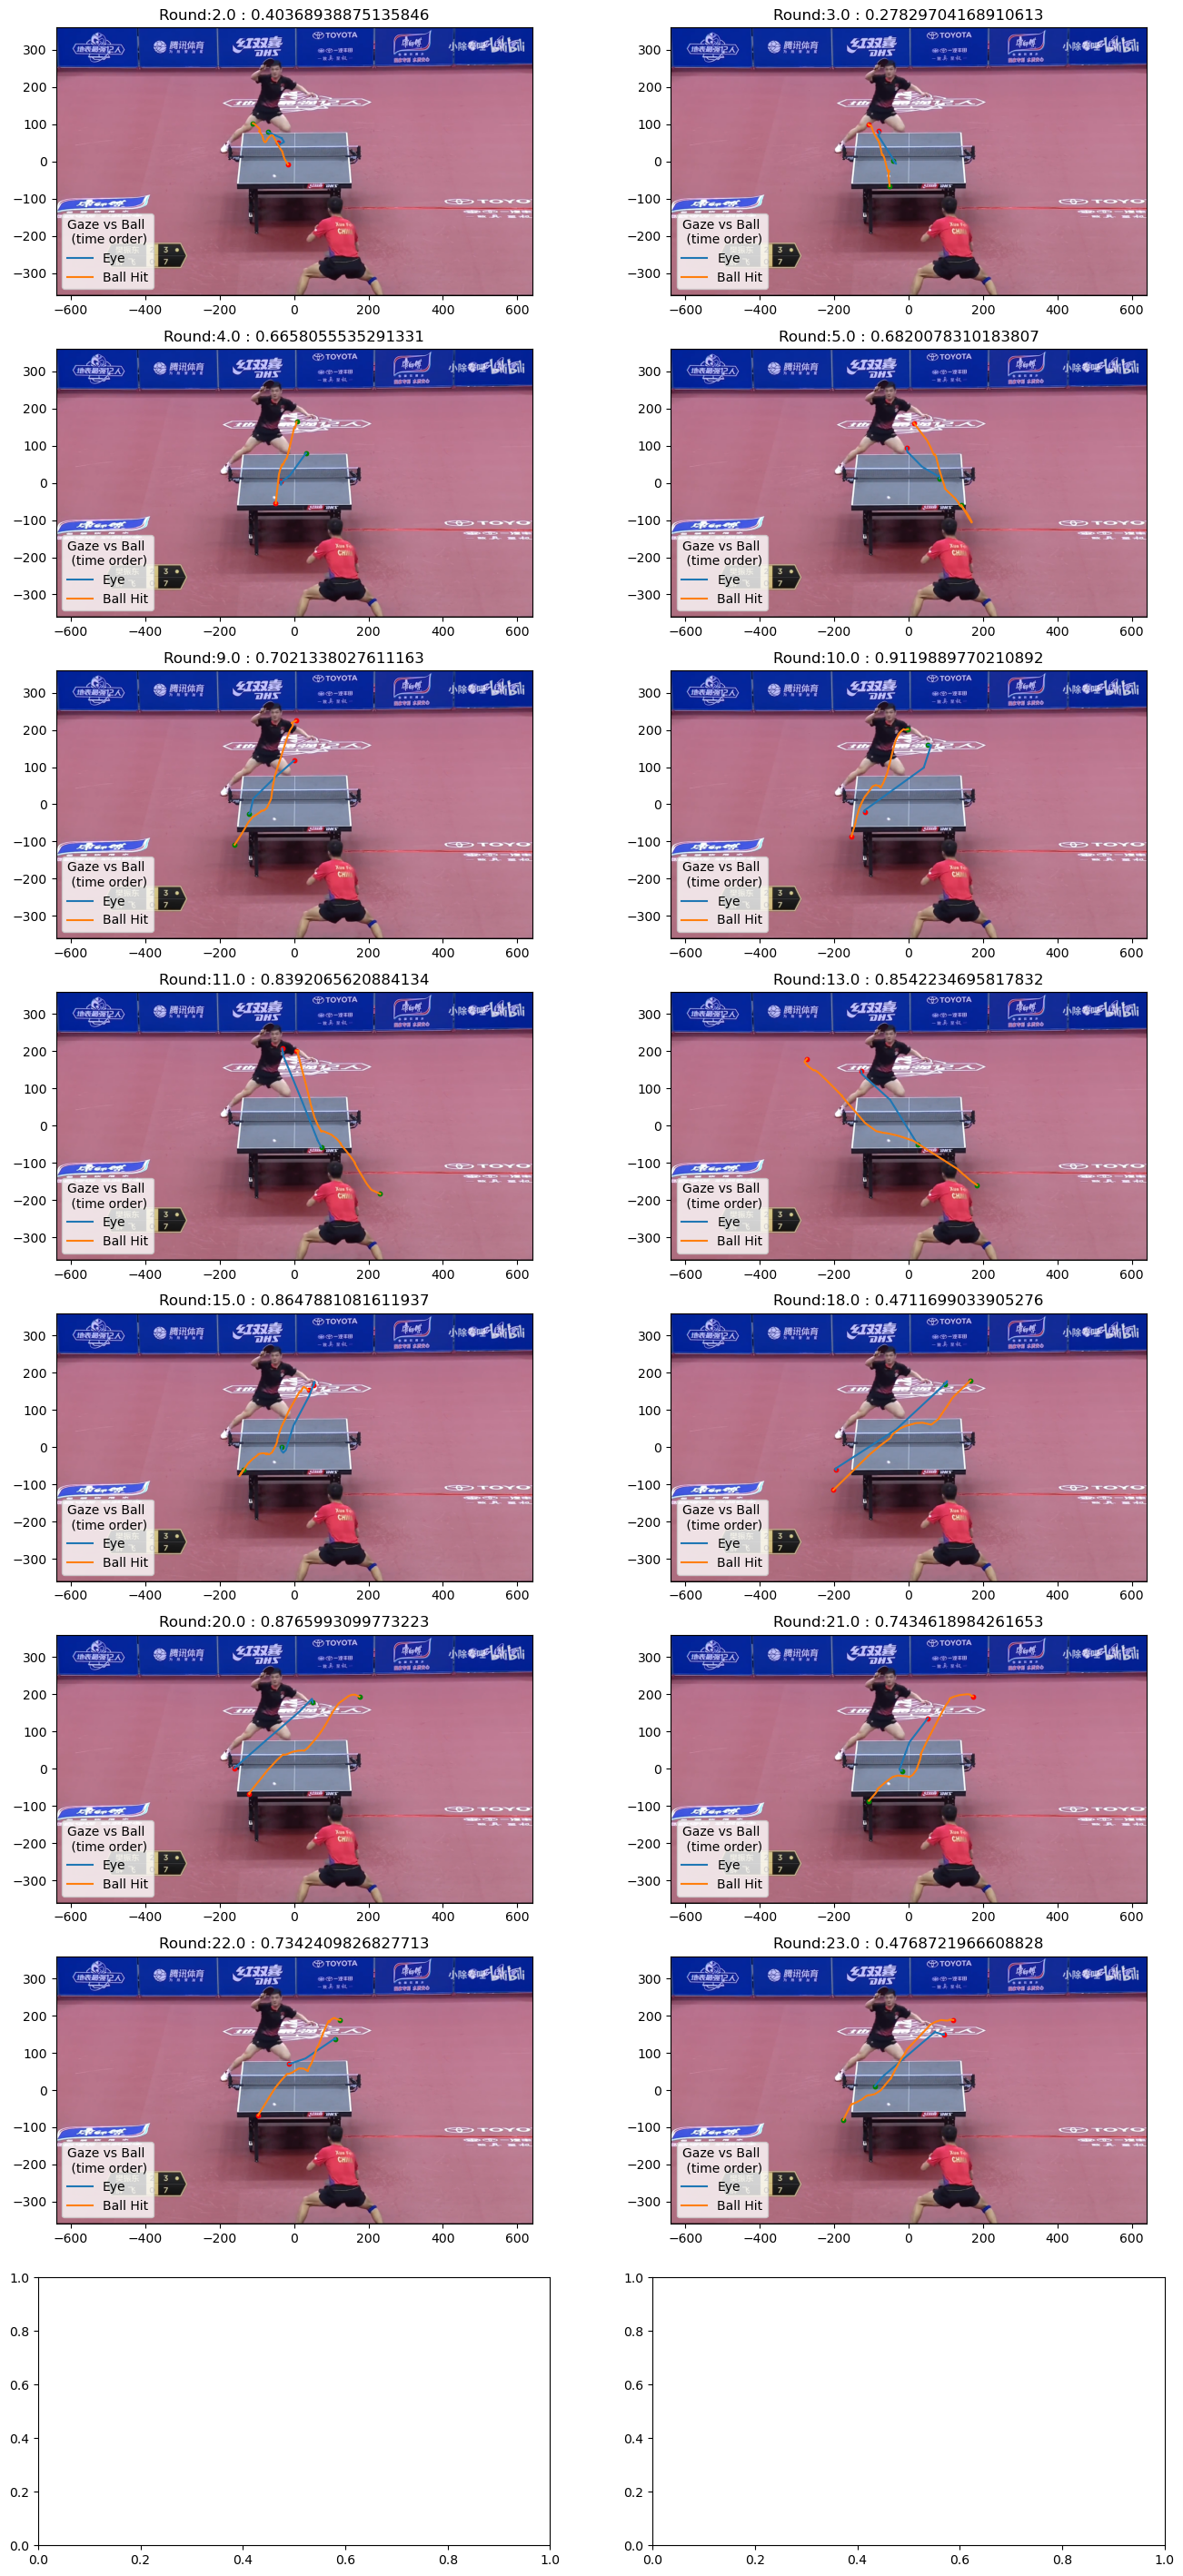

In [19]:
# plt.figure()
fig, ax=plt.subplots(nrows=int(np.ceil(len(match_round)/2)), ncols=2, figsize=(16,9*np.ceil(len(match_round_data.keys())/4)), dpi=100)

img = plt.imread("p7.jpg")
for idx, (round, round_df) in enumerate(match_round_data.items()):
    _row = idx // 2
    _col = idx % 2
    temp_ball = aligned_df[(aligned_df["round"]==round)]
    if len(match_round)>2:
        ax[_row, _col].plot(round_df["Screen.x"], round_df["Screen.y"], label="Eye")
        ax[_row, _col].scatter(round_df.iloc[0, :]["Screen.x"], round_df.iloc[0, :]["Screen.y"], s=10, c="red")
        ax[_row, _col].scatter(round_df.iloc[-1, :]["Screen.x"], round_df.iloc[-1, :]["Screen.y"], s=10, c="green")

        # ax[_row, _col].plot(round_df["Ball.x"], round_df["Ball.y"], label="Ball Hit")
        ax[_row, _col].plot(temp_ball["Ball.x"], temp_ball["Ball.y"], label="Ball Hit")
        ax[_row, _col].scatter(temp_ball.iloc[0, :]["Ball.x"], temp_ball.iloc[0, :]["Ball.y"], s=10, c="red")
        ax[_row, _col].scatter(temp_ball.iloc[-1, :]["Ball.x"], temp_ball.iloc[-1, :]["Ball.y"], s=10, c="green")

        ax[_row, _col].imshow(img, extent=[-640, 640, -360, 360])
        ax[_row, _col].legend( title="Gaze vs Ball\n (time order)", loc="lower left")
        ax[_row, _col].set_title(f"Round:{round} : {round_dtw[round]}")
    else:
        ax[_col].plot(round_df["Screen.x"], round_df["Screen.y"], label="Eye")
        ax[_col].scatter(round_df.iloc[0, :]["Screen.x"], round_df.iloc[0, :]["Screen.y"], s=10, c="red")
        ax[_col].scatter(round_df.iloc[-1, :]["Screen.x"], round_df.iloc[-1, :]["Screen.y"], s=10, c="green")

        # ax[_col].plot(round_df["Ball.x"], round_df["Ball.y"], label="Ball Hit")
        ax[_col].plot(temp_ball["Ball.x"], temp_ball["Ball.y"], label="Ball Hit")
        ax[_col].scatter(temp_ball.iloc[0, :]["Ball.x"], temp_ball.iloc[0, :]["Ball.y"], s=10, c="red")
        ax[_col].scatter(temp_ball.iloc[-1, :]["Ball.x"], temp_ball.iloc[-1, :]["Ball.y"], s=10, c="green")

        ax[_col].imshow(img, extent=[-640, 640, -360, 360])
        ax[_col].legend( title="Gaze vs Ball\n (time order)", loc="lower left")
        ax[_col].set_title(f"Round:{round} : {round_dtw[round]}")

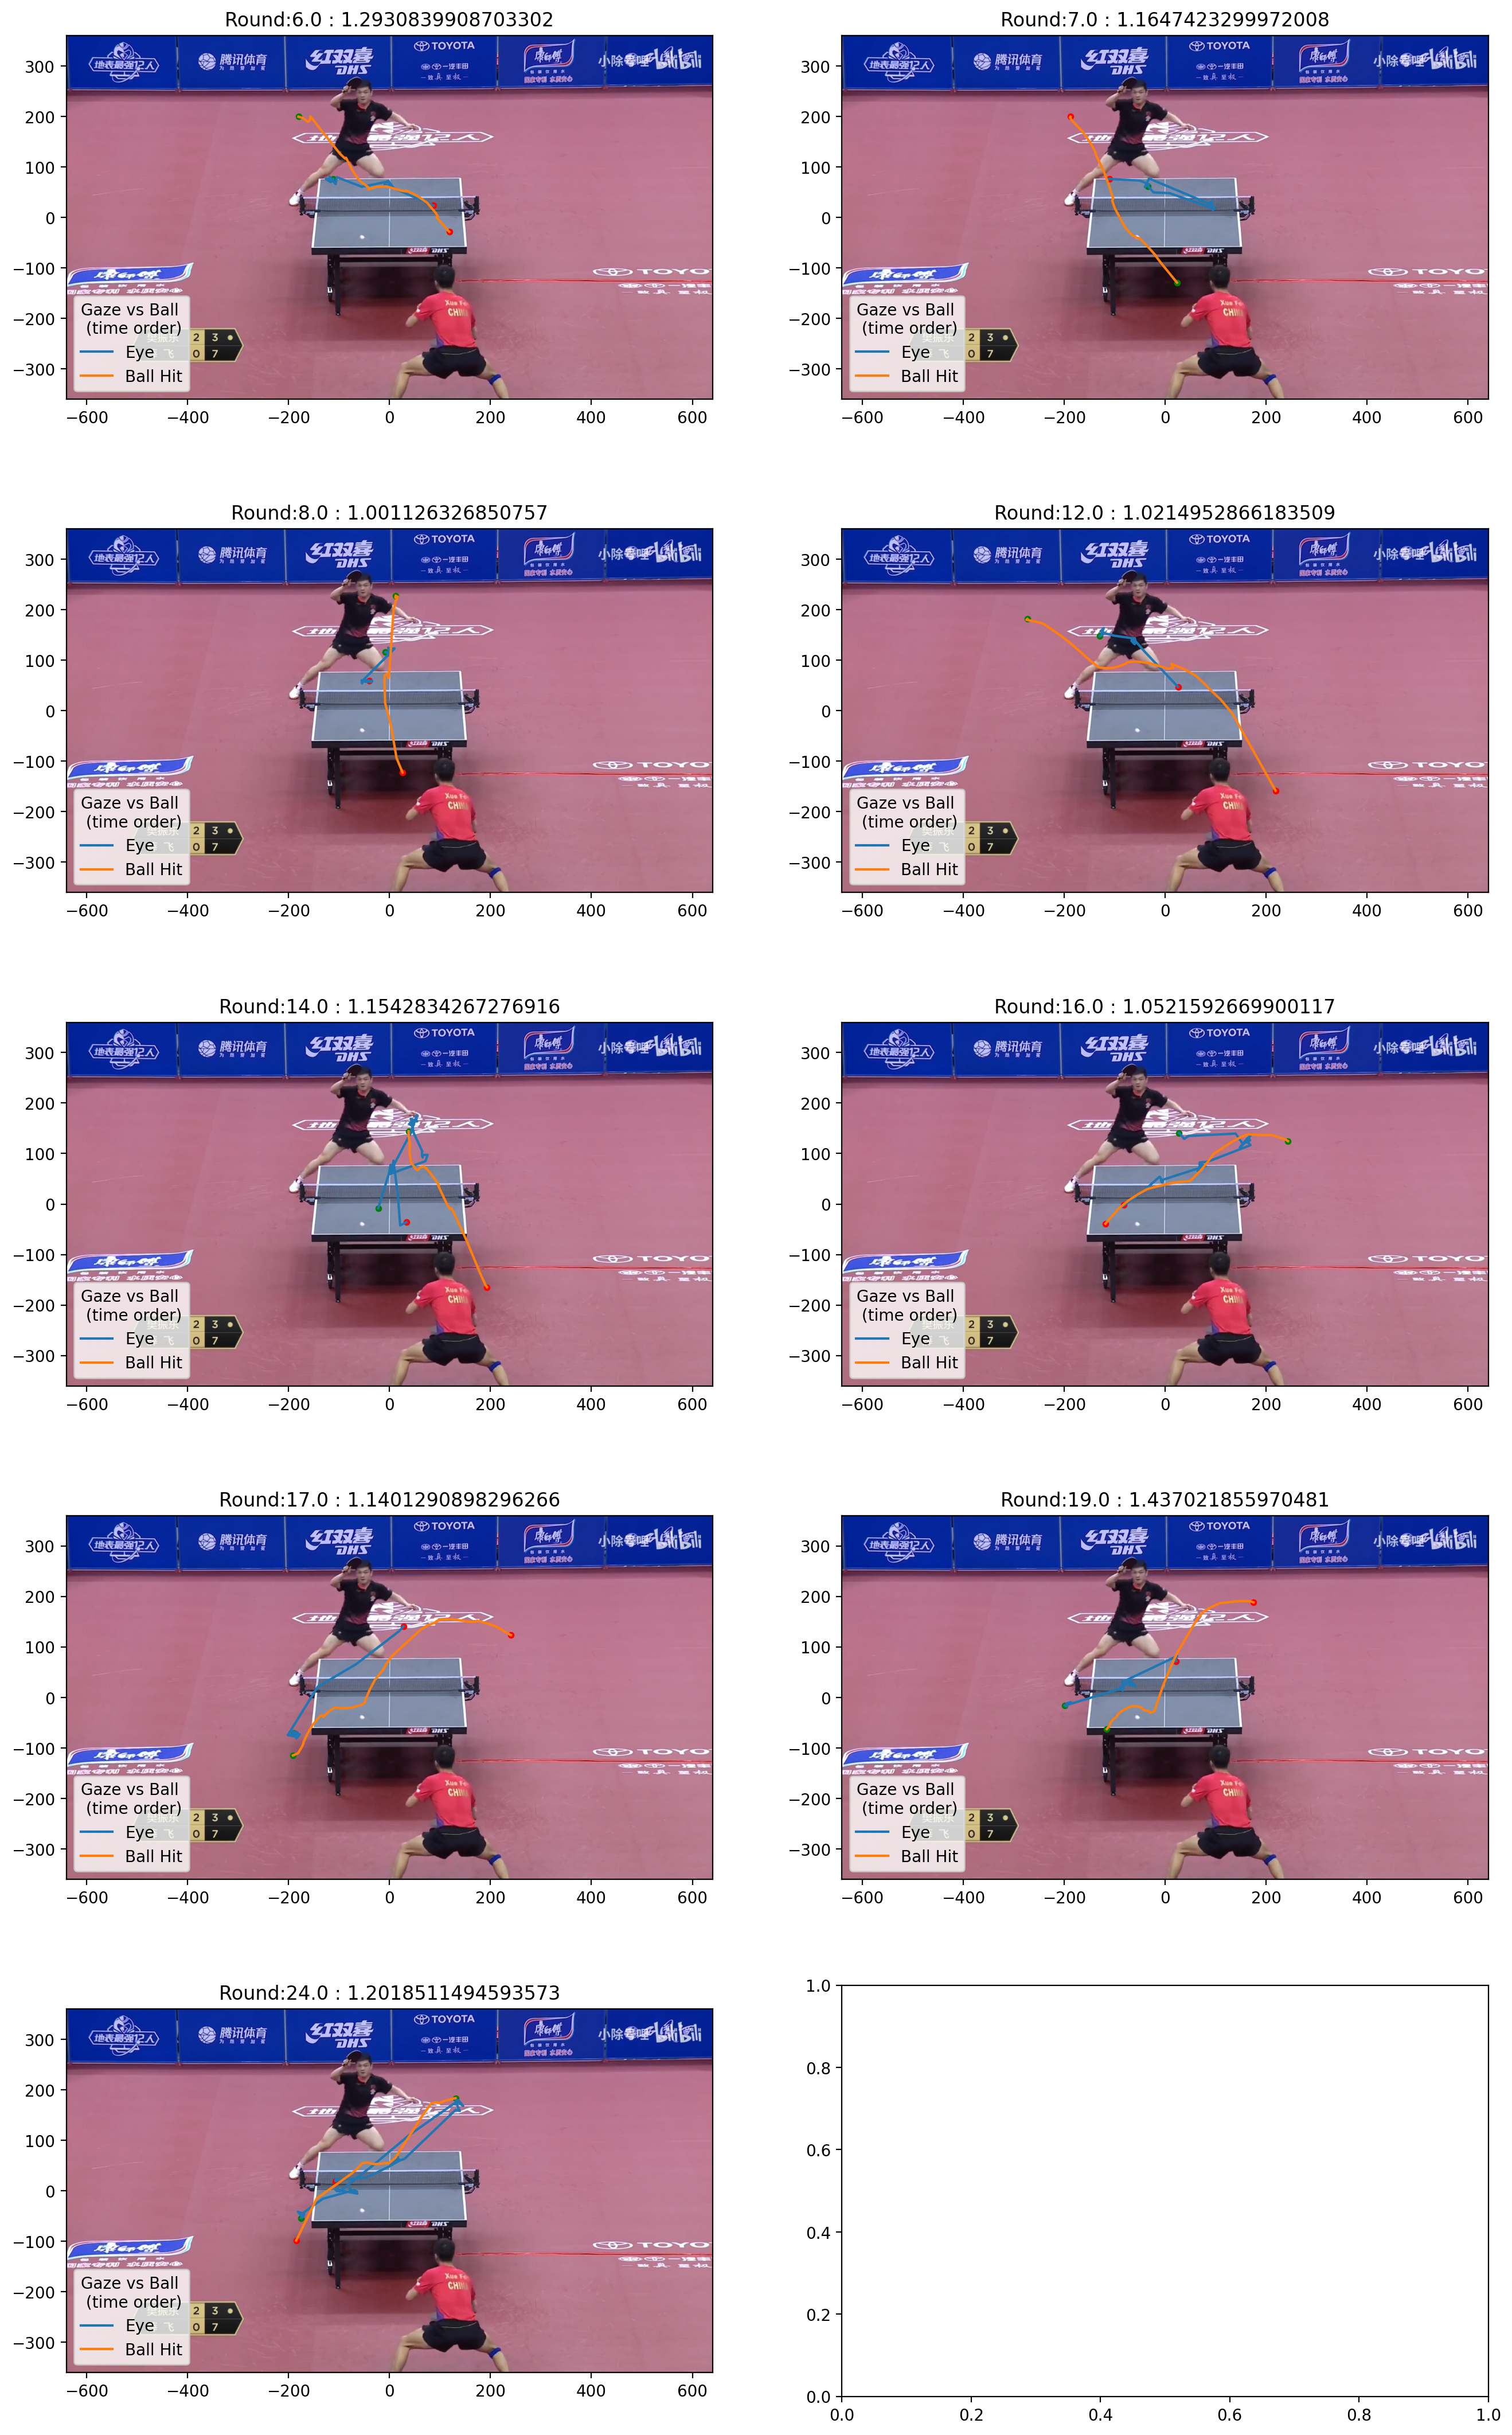

In [30]:
# plt.figure()
rounds = aligned_df["round"].value_counts(sort=False).index
rounds = list(filter(lambda x : x not in match_round.keys(), rounds))

if len(rounds) > 0:

    fig, ax=plt.subplots(nrows=int(np.ceil(len(rounds)/2)), ncols=2, figsize=(16,9*np.ceil(len(rounds)/4)), dpi=200)

    img = plt.imread("p7.jpg")
    for idx, round in enumerate(rounds):
        _row = idx // 2
        _col = idx % 2
        # temp_ball_2round = aligned_df[(aligned_df["round"]==round) | (aligned_df["round"]==round+1)]
        # round_df =  aligned_df[(aligned_df["round"]==round) | (aligned_df["round"]==round+1)]
        temp_ball_2round = aligned_df[(aligned_df["round"]==round)]
        round_df =  aligned_df[(aligned_df["round"]==round + 1)]
        if round_df.shape[0]==0: continue
        if len(match_round)>2:
            ax[_row, _col].plot(round_df["Screen.x"], round_df["Screen.y"], label="Eye")
            ax[_row, _col].scatter(round_df.iloc[0, :]["Screen.x"], round_df.iloc[0, :]["Screen.y"], s=10, c="red")
            ax[_row, _col].scatter(round_df.iloc[-1, :]["Screen.x"], round_df.iloc[-1, :]["Screen.y"], s=10, c="green")

            # ax[_row, _col].plot(round_df["Ball.x"], round_df["Ball.y"], label="Ball Hit")
            ax[_row, _col].plot(temp_ball_2round["Ball.x"], temp_ball_2round["Ball.y"], label="Ball Hit")
            ax[_row, _col].scatter(temp_ball_2round.iloc[0, :]["Ball.x"], temp_ball_2round.iloc[0, :]["Ball.y"], s=10, c="red")
            ax[_row, _col].scatter(temp_ball_2round.iloc[-1, :]["Ball.x"], temp_ball_2round.iloc[-1, :]["Ball.y"], s=10, c="green")

            ax[_row, _col].imshow(img, extent=[-640, 640, -360, 360])
            ax[_row, _col].legend( title="Gaze vs Ball\n (time order)", loc="lower left")
            ax[_row, _col].set_title(f"Round:{round} : {round_dtw[round]}")
        else:
            ax[_col].plot(round_df["Screen.x"], round_df["Screen.y"], label="Eye")
            ax[_col].scatter(round_df.iloc[0, :]["Screen.x"], round_df.iloc[0, :]["Screen.y"], s=10, c="red")
            ax[_col].scatter(round_df.iloc[-1, :]["Screen.x"], round_df.iloc[-1, :]["Screen.y"], s=10, c="green")

            # ax[_col].plot(round_df["Ball.x"], round_df["Ball.y"], label="Ball Hit")
            ax[_col].plot(temp_ball_2round["Ball.x"], temp_ball_2round["Ball.y"], label="Ball Hit")
            ax[_col].scatter(temp_ball_2round.iloc[0, :]["Ball.x"], temp_ball_2round.iloc[0, :]["Ball.y"], s=10, c="red")
            ax[_col].scatter(temp_ball_2round.iloc[-1, :]["Ball.x"], temp_ball_2round.iloc[-1, :]["Ball.y"], s=10, c="green")

            ax[_col].imshow(img, extent=[-640, 640, -360, 360])
            ax[_col].legend( title="Gaze vs Ball\n (time order)", loc="lower left")
            ax[_col].set_title(f"Round:{round} : {round_dtw[round]}")

In [21]:
round = 20.0

temp_ball = aligned_df[aligned_df["round"]==round]
# temp_eye = aligned_df[(aligned_df["round"]==round) | (aligned_df["round"]==round+1)]
temp_eye = aligned_df.loc[match_round[round], :]
temp_eye_2round = aligned_df[ (aligned_df["round"]==round) | (aligned_df["round"]==round+1) ]

/var/folders/rp/3xmh9dds7tl2vhpb6h3ntl1r0000gn/T/ipykernel_36751/303426932.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


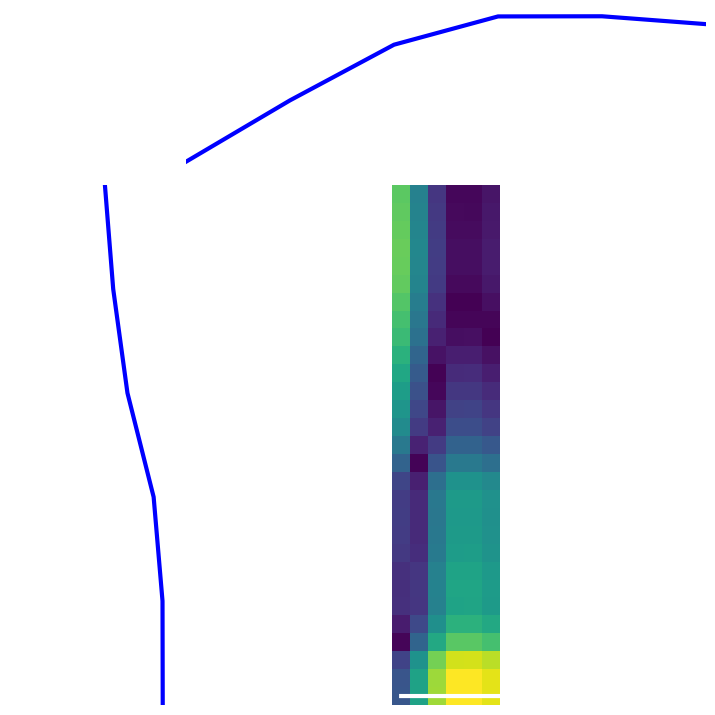

In [22]:
from scipy.spatial.distance import cdist

from tslearn import metrics

path, sim = metrics.dtw_path(temp_eye["Screen.y"], temp_ball["Ball.y"])
# sz = aligned_df.shape[0]

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = cdist(temp_ball.loc[:, ["Ball.y"]], temp_eye.loc[:, ["Screen.y"]])

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(np.arange(temp_eye.shape[0]), temp_eye["Screen.y"], "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, temp_eye.shape[0] - 1))

ax_s_y.plot(- temp_ball["Ball.y"], np.arange(temp_ball.shape[0]), "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, temp_eye.shape[0] - 1))

plt.tight_layout()
plt.show()

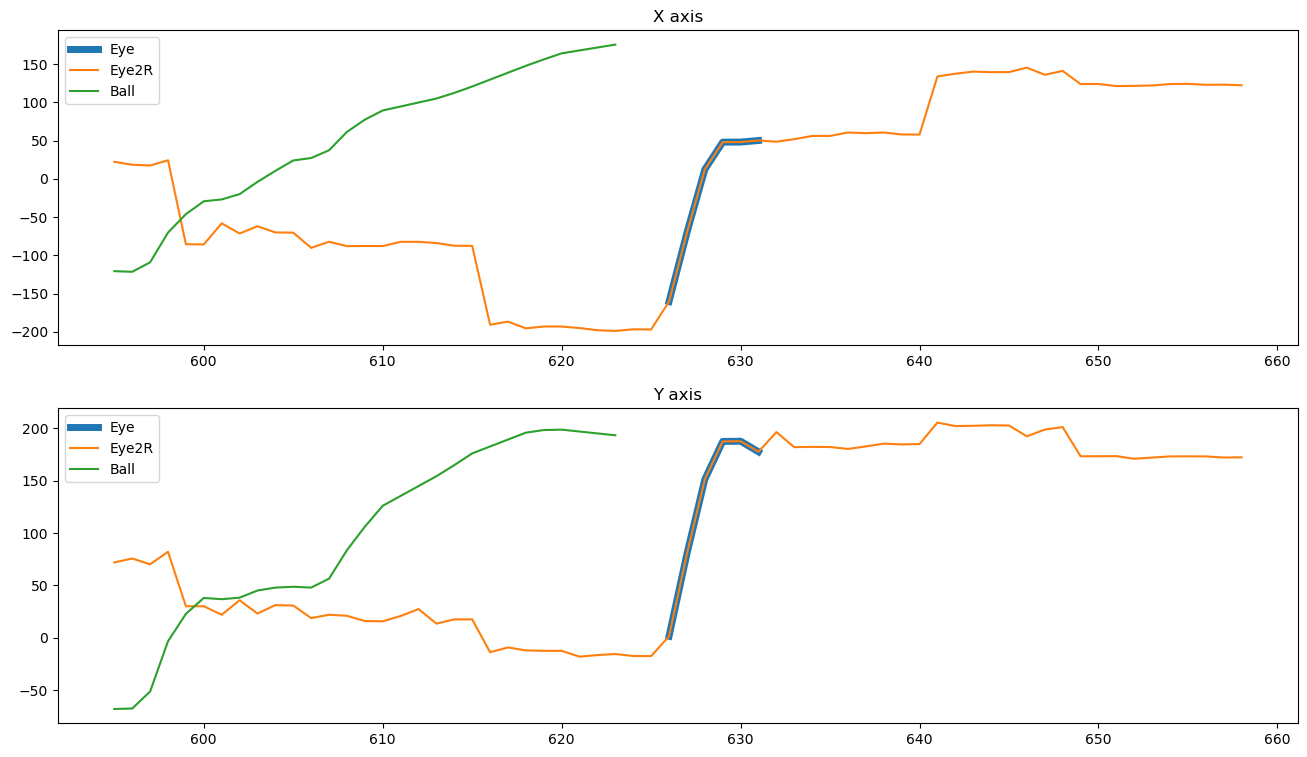

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,9),dpi=100)

axs[0].plot(temp_eye["Screen.x"], label="Eye", linewidth=5)
axs[0].plot(temp_eye_2round["Screen.x"], label="Eye2R")
axs[0].plot(temp_ball["Ball.x"], label="Ball")
axs[0].set_title("X axis")
axs[0].legend()

axs[1].plot(temp_eye["Screen.y"], label="Eye", linewidth=5)
axs[1].plot(temp_eye_2round["Screen.y"], label="Eye2R")
axs[1].plot(temp_ball["Ball.y"], label="Ball")
axs[1].set_title("Y axis")
axs[1].legend()

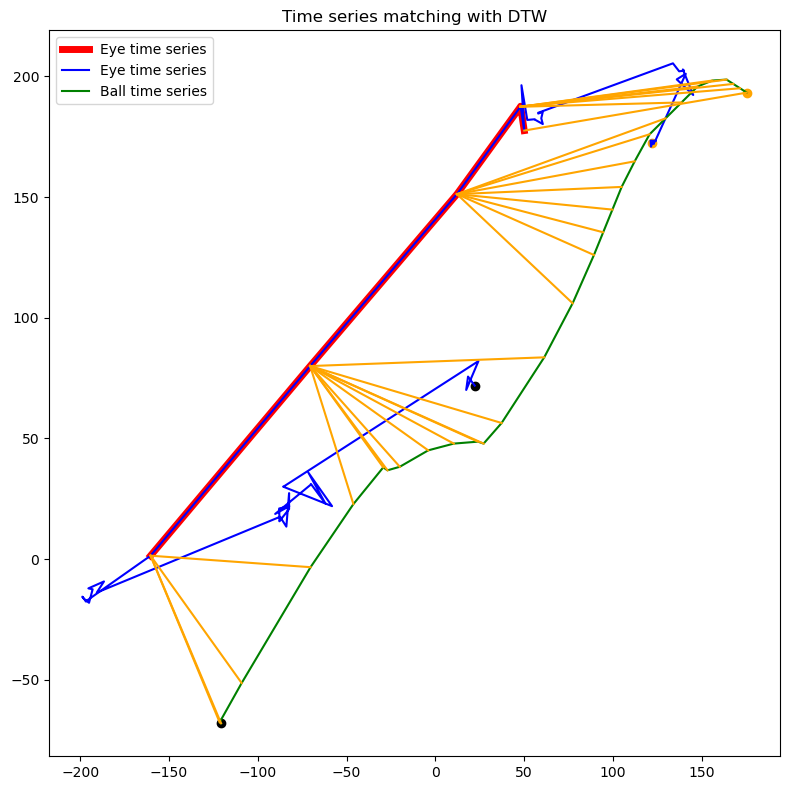

In [24]:
plt.figure(figsize=(8, 8))

path, sim = metrics.dtw_path(minmax_scale(temp_eye.loc[:, ["Screen.x", "Screen.y"]]), minmax_scale(temp_ball.loc[:, ["Ball.x", "Ball.y"]]))

plt.plot(temp_eye["Screen.x"], temp_eye["Screen.y"], "r-", lw=5, label='Eye time series')
plt.plot(temp_eye_2round["Screen.x"], temp_eye_2round["Screen.y"], "b-", label='Eye time series')
plt.plot(temp_ball["Ball.x"], temp_ball["Ball.y"], "g-", label='Ball time series')
plt.scatter(temp_eye_2round.iloc[0]["Screen.x"], temp_eye_2round.iloc[0]["Screen.y"], c="black")
plt.scatter(temp_eye_2round.iloc[-1]["Screen.x"], temp_eye_2round.iloc[-1]["Screen.y"], c="orange")
plt.scatter(temp_ball.iloc[0]["Ball.x"], temp_ball.iloc[0]["Ball.y"], c="black")
plt.scatter(temp_ball.iloc[-1]["Ball.x"], temp_ball.iloc[-1]["Ball.y"], c="orange")

for positions in path:
    plt.plot([temp_eye["Screen.x"].iloc[positions[0]], temp_ball["Ball.x"].iloc[positions[1]]],
             [temp_eye["Screen.y"].iloc[positions[0]], temp_ball["Ball.y"].iloc[positions[1]]],
               color='orange')

plt.legend()
plt.title("Time series matching with DTW")

plt.tight_layout()
plt.show()